# Dependencies


In [3]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install opencv-python --upgrade
# !pip install ultralytics --upgrade
# !pip install torchmetrics --upgrade
# !pip install grad-cam --upgrade
# !pip install natsort --upgrade
# !pip install Pillow --upgrade
# !pip install wandb --upgrade
# # !pip install deepface --quiet

### >Restart kernel!


In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as tnf
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image, ImageChops
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from ultralytics import YOLO
import hashlib
from natsort import natsorted
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Dataset


## Generate Dataset


### Testing different approaches in facial detection


In [5]:
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Directory containing frames
frame_dir = "/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline"

# List of image files in the directory
frame_files = natsorted(
    [f for f in os.listdir(frame_dir) if os.path.isfile(os.path.join(frame_dir, f))]
)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Replace with the appropriate model if needed

# Process frames from the directory
for frame_file in frame_files:
    # Load the frame (image) using OpenCV
    frame_path = os.path.join(frame_dir, frame_file)
    frame = cv2.imread(frame_path)

    # Run detection
    results = model(frame)

    # Extract the boxes, scores, and classes from results
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Get bounding box coordinates
    scores = results[0].boxes.conf.cpu().numpy()  # Get confidence scores
    classes = results[0].boxes.cls.cpu().numpy()  # Get class IDs

    print(boxes, classes)
    # Filter and draw boxes for persons (class ID 0)
    for box, score, cls in zip(boxes, scores, classes):
        if cls == 0 and score >= 0.3:  # Class ID 0 is typically for persons, adjust threshold as needed
            x1, y1, x2, y2 = map(int, box)  # Convert box to integer
            label = f"Person: {score:.2f}"
            # Draw rectangle around persons
            h_padding = 0 / 100  # Horizontal padding in percent
            v_padding = 0 / 100  # Vertical padding in percent
            include_head_offset = 0  # 2.5  # Offset to include head in the resultant crops
            cv2.rectangle(
                frame,
                (x1 - int(x1 * h_padding), y1 - int(y1 * include_head_offset * v_padding)),
                (x2 + int(x2 * h_padding), y2 + int(y2 * v_padding)),
                (0, 255, 0),
                2,
            )

    # Convert back to RGB for Matplotlib
    rgb_frame_with_faces = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame with person boxes using Matplotlib
    plt.imshow(rgb_frame_with_faces)
    plt.title(f"Frame: {frame_file}")
    plt.axis("off")  # Hide axes
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline'

### Face detection pipeline


In [ ]:
# Detect face using haar cascade
def detect_face_depracted(image_path, log_level=0):
    try:
        # Load the Haar cascade file
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        )

        # Read the image
        img = cv2.imread(image_path)

        if img is None:
            if log_level >= 2:
                print(f"Unable to read {image_path}. Skipping...")
            return False

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4, minSize=(30, 30))

        if len(faces) > 0:
            if log_level >= 2:
                print(f"Face detected in {image_path}")
            return faces, True  # Return detected faces
        else:
            if log_level >= 2:
                print(f"No face detected in {image_path}")
            return None, True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

In [ ]:
# Configuration parameters
# video_path = '/kaggle/input/celeb-df-v2-dataset/Celeb-real/id0_0000.mp4'
# output_dir = '/kaggle/working/temp'
# frame_rate = 2  # Frames per second to extract


def extract_frames_with_face_derpracated(
    video_path, frame_output_dir, id="frame", frame_rate=2, log_level=0
):

    # Ensure output directory exists
    os.makedirs(frame_output_dir, exist_ok=True)

    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)

    frame_count = 0
    saved_frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Extract frames at the specified interval
        if frame_count % frame_interval == 0:
            # Temporarily save the current frame to disk
            temp_frame_path = os.path.join(frame_output_dir, f"{id}_{frame_count}.jpg")
            cv2.imwrite(temp_frame_path, frame)

            try:
                # Detect face in the frame
                _, face_found = detect_face(image_path=temp_frame_path, log_level=log_level)

                if face_found:
                    if log_level >= 2:
                        print(f"Face detected in frame {frame_count}")

                    # Save the frame with a detected face
                    output_frame_path = os.path.join(frame_output_dir, f"{id}_{saved_frame_count}.jpg")
                    cv2.imwrite(output_frame_path, frame)
                    saved_frame_count += 1
                else:
                    if log_level >= 2:
                        print(f"No face detected in frame {frame_count}")

            except Exception as e:
                print(f"Error processing frame {frame_count}: {e}")

            # Remove the temporary frame file to save disk space
            os.remove(temp_frame_path)

        frame_count += 1

    cap.release()
    # cv2.destroyAllWindows()
    if log_level == 1:
        # print(f"Total frames processed: {frame_count} in {video_path}")
        print(f"Frames with detected faces saved: {saved_frame_count}/{frame_count} from {video_path}")

In [ ]:
# !mkdir '/kaggle/working/temp_dataset/fake'

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Directory containing frames
frame_dir = "/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline"

# List of image files in the directory
frame_files = natsorted(
    [f for f in os.listdir(frame_dir) if os.path.isfile(os.path.join(frame_dir, f))]
)

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Replace with the appropriate model if needed

# Process frames from the directory
for frame_file in frame_files:
    # Load the frame (image) using OpenCV
    frame_path = os.path.join(frame_dir, frame_file)
    frame = cv2.imread(frame_path)

    # Run detection
    results = model(frame)

    # Extract the boxes, scores, and classes from results
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Get bounding box coordinates
    scores = results[0].boxes.conf.cpu().numpy()  # Get confidence scores
    classes = results[0].boxes.cls.cpu().numpy()  # Get class IDs

    print(boxes, classes)
    # Filter and draw boxes for persons (class ID 0)
    for box, score, cls in zip(boxes, scores, classes):
        if cls == 0 and score >= 0.3:  # Class ID 0 is typically for persons, adjust threshold as needed
            x1, y1, x2, y2 = map(int, box)  # Convert box to integer
            label = f"Person: {score:.2f}"
            # Draw rectangle around persons
            h_padding = 0 / 100  # Horizontal padding in percent
            v_padding = 0 / 100  # Vertical padding in percent
            include_head_offset = 0  # 2.5  # Offset to include head in the resultant crops
            cv2.rectangle(
                frame,
                (x1 - int(x1 * h_padding), y1 - int(y1 * include_head_offset * v_padding)),
                (x2 + int(x2 * h_padding), y2 + int(y2 * v_padding)),
                (0, 255, 0),
                2,
            )

    # Convert back to RGB for Matplotlib
    rgb_frame_with_faces = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame with person boxes using Matplotlib
    plt.imshow(rgb_frame_with_faces)
    plt.title(f"Frame: {frame_file}")
    plt.axis("off")  # Hide axes
    plt.show()

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Replace with the appropriate model if needed


# Detect face using YOLOv8
def detect_face(frame, threshold=0.5, log_level=0):
    try:
        # Run detection
        results = model(frame)

        # Extract the boxes, scores, and classes from results
        boxes = results[0].boxes.xyxy.cpu().numpy()  # Get bounding box coordinates
        scores = results[0].boxes.conf.cpu().numpy()  # Get confidence scores
        classes = results[0].boxes.cls.cpu().numpy()  # Get class IDs

        detected_faces = {}
        index = 0
        face_detected = False

        # Filter and save boxes for persons (class ID 0 typically corresponds to persons/faces)
        for box, score, object_class in zip(boxes, scores, classes):
            if (
                object_class == 0 and score > threshold
            ):  # Class ID 0 is typically for persons, adjust as needed
                x1, y1, x2, y2 = map(int, box)  # Convert box coordinates to integer
                top_left = (x1, y1)
                bottom_right = (x2, y2)

                # Save the detected face box coordinates
                detected_faces[index] = {
                    "top_left": top_left,
                    "bottom_right": bottom_right,
                    "score": score,
                }
                index += 1
                face_detected = True  # Set flag to True as faces were detected

        # Logging if required
        if log_level >= 2:
            if face_detected:
                print(f"Faces detected in {image_path}")
            else:
                print(f"No faces detected in {image_path}")

        return detected_faces, face_detected  # Return the faces and detection status

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, False  # Return None and False in case of an error

In [ ]:
image_path = "/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/gettyimages-1425797951-612x612.jpg"
# Check if the image path is valid
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"Image file {image_path} not found")

# Load the frame (image) using OpenCV
frame = cv2.imread(image_path)
print(detect_face(frame))

In [ ]:
def generate_crops(frame, frame_output_dir, frame_index, detected_faces, frame_id, show_crops=False):
    # Save each detected face as a cropped image
    for face_idx, face_data in detected_faces.items():
        print("face_data", face_data)
        top_left = face_data["top_left"]
        bottom_right = face_data["bottom_right"]

        # Crop the face from the frame
        face_crop = frame[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]

        # Generate output path for the face crop
        output_face_path = os.path.join(
            frame_output_dir, f"{frame_id}_{frame_index}_face{face_idx}.jpg"
        )

        # Save the face crop
        cv2.imwrite(output_face_path, face_crop)

        # Extra logic to show crops and edge coordinates for debugging
        if show_crops:
            # Draw red circles on the corners for debugging
            #             cv2.circle(face_crop, (0, 0), 5, (255, 0, 0), -1)  # Top-left (0,0 in the cropped frame)
            #             cv2.circle(face_crop, (face_crop.shape[1]-1, face_crop.shape[0]-1), 5, (255, 0, 0), -1)  # Bottom-right

            # Annotate the coordinates for debugging
            #             cv2.putText(face_crop, f"({top_left[0]},{top_left[1]})", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            #             cv2.putText(face_crop, f"({bottom_right[0]},{bottom_right[1]})",
            #                         (face_crop.shape[1] - 100, face_crop.shape[0] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

            # Resize the face crop to 224x224
            face_crop = cv2.resize(face_crop, (224, 224), interpolation=cv2.INTER_CUBIC)
            # Display the face crop using matplotlib
            plt.imshow(
                cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            )  # Convert BGR (OpenCV format) to RGB (Matplotlib format)
            plt.title(f"Face {face_idx} from Frame {frame_index}")
            plt.axis("off")  # Hide axes for cleaner visualization
            plt.show()

In [ ]:
import os
import cv2
from PIL import Image

# List of supported image formats
SUPPORTED_IMAGE_FORMATS = [".jpg", ".jpeg", ".png"]

# List of supported video formats
SUPPORTED_VIDEO_FORMATS = [".mp4", ".avi", ".mov"]


def check_media_type(file_path):
    if not os.path.exists(file_path):
        return "File does not exist"

    file_extension = os.path.splitext(file_path)[1].lower()

    if file_extension in SUPPORTED_IMAGE_FORMATS:
        try:
            with Image.open(file_path) as img:
                img.verify()
            return "Image"
        except:
            return "Invalid image file"

    elif file_extension in SUPPORTED_VIDEO_FORMATS:
        try:
            video = cv2.VideoCapture(file_path)
            if video.isOpened():
                video.release()
                return "Video"
            else:
                return "Invalid video file"
        except:
            return "Invalid video file"

    else:
        return "Not a supported image or video format"


def process_media_file(media_path, output_dir, frame_id="frame", frame_rate=2, log_level=0):
    """
    Process media and extract face crops
    """
    media_type = check_media_type(media_path)

    if media_type == "Image":
        process_image(media_path, output_dir, frame_id, log_level)
    elif media_type == "Video":
        process_video(media_path, output_dir, frame_id, frame_rate, log_level)
    else:
        print(f"Unsupported media type: {media_type}")


def process_image(image_path, output_dir, frame_id="frame", log_level=0):
    try:
        frame = cv2.imread(image_path)
        detected_faces, face_found = detect_face(frame=frame, threshold=0.3, log_level=log_level)
        if face_found:
            if log_level >= 2:
                print(f"Face(s) detected in image {image_path}")
            generate_crops(
                frame=frame,
                frame_output_dir=output_dir,
                frame_index=0,
                detected_faces=detected_faces,
                frame_id=frame_id,
                show_crops=False,
            )
        else:
            if log_level >= 2:
                print(f"No face detected in image {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")


def process_video(video_path, output_dir, frame_id, frame_rate, log_level=0):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(fps / frame_rate)
    frame_count = 0
    saved_frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            try:
                detected_faces, face_found = detect_face(
                    frame=frame, threshold=0.4, log_level=log_level
                )
                if face_found:
                    if log_level >= 2:
                        print(f"Face(s) detected in frame {frame_count}")
                    generate_crops(
                        frame=frame,
                        frame_output_dir=output_dir,
                        frame_index=saved_frame_count,
                        detected_faces=detected_faces,
                        frame_id=frame_id,
                        show_crops=False,
                    )
                    saved_frame_count += 1
                else:
                    if log_level >= 2:
                        print(f"No face detected in frame {frame_count}")
            except Exception as e:
                print(f"Error processing frame {frame_count}: {e}")
        frame_count += 1
    cap.release()
    if log_level == 1:
        print(f"Frames with detected faces saved: {saved_frame_count}/{frame_count} from {video_path}")


# Example usage
media_path = f"{DATA_SET_DIR}/Celeb-synthesis/id0_id26_0008.mp4"
output_dir = "/kaggle/working/temp_face_crops"
process_media_file(media_path, output_dir, frame_id="frame", frame_rate=2, log_level=1)

Error processing frame 0: name 'detect_face' is not defined
Error processing frame 15: name 'detect_face' is not defined
Error processing frame 30: name 'detect_face' is not defined
Error processing frame 45: name 'detect_face' is not defined
Error processing frame 60: name 'detect_face' is not defined
Error processing frame 75: name 'detect_face' is not defined
Error processing frame 90: name 'detect_face' is not defined
Error processing frame 105: name 'detect_face' is not defined
Error processing frame 120: name 'detect_face' is not defined
Error processing frame 135: name 'detect_face' is not defined
Error processing frame 150: name 'detect_face' is not defined
Error processing frame 165: name 'detect_face' is not defined
Error processing frame 180: name 'detect_face' is not defined
Error processing frame 195: name 'detect_face' is not defined
Error processing frame 210: name 'detect_face' is not defined
Error processing frame 225: name 'detect_face' is not defined
Error processing

In [2]:
class MediaProcessor:
    """
    A class for detecting and extracting faces from images and videos using YOLOv8.
    """

    def __init__(self, model_path="yolov8n.pt", threshold=0.5, log_level=0, FRAMES_FILE_FORMAT="jpg"):
        """
        Initialize the FaceDetector.

        Args:
            model_path (str): Path to the YOLOv8 model file.
            threshold (float): Confidence threshold for face detection.
            log_level (int): Level of logging (0: None, 1: Basic, 2: Verbose).
        """
        self.model = YOLO(model_path)
        self.threshold = threshold
        self.log_level = log_level
        self.supported_image_formats = [".jpg", ".jpeg", ".png"]
        self.supported_video_formats = [".mp4", ".avi", ".mov"]
        self.FRAMES_FILE_FORMAT = FRAMES_FILE_FORMAT
        print("Warning: frame_rate value ignored for Image media\nReason: Image input")
        print(
            "\nWarning: naming scheme: \nImage: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}\nVideo: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}\n"
        )

    def detect_face(self, frame):
        """
        Detect faces in a given frame.

        Args:
            frame (numpy.ndarray): Input image frame.

        Returns:
            tuple: Detected faces (dict) and a boolean indicating if faces were found.
        """
        try:
            # Run detection
            if self.log_level >= 3:
                results = self.model(frame)
            else:
                results = self.model(frame, verbose=False)

            # Extract boxes, scores, and classes
            boxes = results[0].boxes.xyxy.cpu().numpy()
            scores = results[0].boxes.conf.cpu().numpy()
            classes = results[0].boxes.cls.cpu().numpy()

            detected_faces = {}
            face_detected = False

            # Filter and save boxes for persons (class ID 0)
            for index, (box, score, object_class) in enumerate(zip(boxes, scores, classes)):
                if object_class == 0 and score > self.threshold:
                    x1, y1, x2, y2 = map(int, box)
                    detected_faces[index] = {
                        "top_left": (x1, y1),
                        "bottom_right": (x2, y2),
                        "score": score,
                    }
                    face_detected = True

            # Logging
            if self.log_level >= 2:
                print(f"{'Faces' if face_detected else 'No faces'} detected in frame")

            return detected_faces, face_detected

        except Exception as e:
            print(f"Error processing frame: {e}")
            return None, False

    def generate_crops(
        self, frame, output_dir, frame_index, detected_faces, frame_id, show_crops=False
    ):
        """
        Generate and save face crops from a frame.

        Args:
            frame (numpy.ndarray): Input image frame.
            output_dir (str): Directory to save face crops.
            frame_index (int): Index of the current frame.
            detected_faces (dict): Dictionary of detected faces.
            frame_id (str): Identifier for the frame.
            show_crops (bool): Whether to display the crops (for debugging).
        """
        for face_idx, face_data in detected_faces.items():
            top_left = face_data["top_left"]
            bottom_right = face_data["bottom_right"]

            # Crop the face from the frame
            face_crop = frame[top_left[1] : bottom_right[1], top_left[0] : bottom_right[0]]

            if show_crops:
                # Resize and display the face crop (for debugging)
                face_crop_resized = cv2.resize(face_crop, (224, 224), interpolation=cv2.INTER_CUBIC)
                cv2.imshow(f"Face {face_idx} from Frame {frame_index}", face_crop_resized)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

            # Generate output path for the face crop
            output_face_path = os.path.join(
                output_dir, f"{frame_id}_{frame_index}_{face_idx}.{self.FRAMES_FILE_FORMAT}"
            )

            # Check if the crop already exists
            if os.path.exists(output_face_path):
                if self.log_level >= 2:
                    print(f"Skipping crop {output_face_path}: already exists")
                continue
            if self.log_level >= 1:
                print("Crop saved at: ", output_face_path)
            # Save the face crop
            cv2.imwrite(output_face_path, face_crop)

    def check_media_type(self, file_path):
        """
        Check the type of media file.

        Args:
            file_path (str): Path to the media file.

        Returns:
            str: Type of media ('Image', 'Video', or error message).
        """
        if not os.path.exists(file_path):
            return "File does not exist"

        file_extension = os.path.splitext(file_path)[1].lower()

        if file_extension in self.supported_image_formats:
            try:
                with Image.open(file_path) as img:
                    img.verify()
                return "Image"
            except:
                return "Invalid image file"
        elif file_extension in self.supported_video_formats:
            try:
                video = cv2.VideoCapture(file_path)
                if video.isOpened():
                    video.release()
                    return "Video"
                else:
                    return "Invalid video file"
            except:
                return "Invalid video file"
        else:
            return "Not a supported image or video format"

    def process_image(self, image_path, output_dir, frame_id, generate_crops_flag):
        """
        Process a single image and extract face crops.

        Args:
            image_path (str): Path to the input image.
            output_dir (str): Directory to save face crops.
            frame_id (str): Identifier for the frame.
        """
        try:
            frame = cv2.imread(image_path)

            detected_faces, face_found = self.detect_face(frame)

            if face_found:
                if self.log_level >= 2:
                    print(f"Face(s) detected in image {image_path}")
                if generate_crops_flag:
                    self.generate_crops(frame, output_dir, 0, detected_faces, frame_id)
                else:
                    frame_index = 0
                    # Generate output path for the face crop
                    output_face_path = os.path.join(
                        output_dir, f"{frame_id}_{frame_index}.{self.FRAMES_FILE_FORMAT}"
                    )  # frame_index = 0 for all still images

                    # Check if the image already exists
                    if os.path.exists(output_face_path):
                        if self.log_level >= 2:
                            print(f"Skipping image {output_face_path}: already exists")
                        return

                    print("Frame saved at: ", output_face_path)
                    # Save the frame
                    cv2.imwrite(output_face_path, frame)
            else:
                if self.log_level >= 1:
                    print(f"No face detected in image {image_path}")
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    def process_video(self, video_path, output_dir, frame_id, frame_rate, generate_crops_flag):
        """
        Process a video and extract face crops from frames.

        Args:
            video_path (str): Path to the input video.
            output_dir (str): Directory to save face crops.
            frame_id (str): Identifier for the frames.
            frame_rate (int): Rate at which to extract frames.
        """
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps / frame_rate)
        frame_count = 0
        saved_frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % frame_interval == 0:
                try:
                    detected_faces, face_found = self.detect_face(frame)
                    if face_found:
                        if self.log_level >= 2:
                            print(f"Face(s) detected in frame {frame_count}")
                        if generate_crops_flag:
                            self.generate_crops(
                                frame, output_dir, saved_frame_count, detected_faces, frame_id
                            )
                        else:
                            # Generate output path for the face crop
                            output_face_path = os.path.join(
                                output_dir, f"{frame_id}_{saved_frame_count}.{self.FRAMES_FILE_FORMAT}"
                            )

                            # Check if the frame already exists
                            if os.path.exists(output_face_path):
                                if self.log_level >= 1:
                                    print(f"Skipping frame {output_face_path}: already exists")
                            else:
                                # Save the frame
                                cv2.imwrite(output_face_path, frame)
                        saved_frame_count += 1
                    else:
                        if self.log_level >= 2:
                            print(f"No face detected in frame {frame_count}")
                except Exception as e:
                    print(f"Error processing frame {frame_count}: {e}")
            frame_count += 1
        cap.release()
        if self.log_level >= 1:
            print(
                f"Frames with detected faces saved: {saved_frame_count}/{frame_count} from {video_path}"
            )

    def generate_6_digit_hash(self, input_string):
        # Create a hash object
        hash_object = hashlib.sha256(input_string.encode())
        # Get the hexadecimal digest of the hash
        hex_dig = hash_object.hexdigest()
        # Convert the first 6 characters of the hash to an integer
        hash_int = int(hex_dig[:6], 16)
        # Ensure the hash is 6 digits long
        hash_6_digit = str(hash_int).zfill(6)
        return hash_6_digit

    def hash_file_content(self, file_path):
        with open(file_path, "rb") as f:
            file_content = f.read()
        return self.generate_6_digit_hash(file_content.decode("latin1"))

    def hash_file_name(self, file_path):
        file_name = os.path.basename(file_path)
        return self.generate_6_digit_hash(file_name)

    def generate_combined_hash(self, file_path):
        file_content_hash = self.hash_file_content(file_path)
        file_name_hash = self.hash_file_name(file_path)
        return f"{file_content_hash}_{file_name_hash}"

    def process_media_file(self, media_path, output_dir, generate_crops_flag, frame_rate=2):
        """
        Process a media file (image or video) and extract face crops.

        Args:
            media_path (str): Path to the input media file.
            output_dir (str): Directory to save face crops.
            frame_id (str): Identifier for the frames.
            frame_rate (int): Rate at which to extract frames (for videos).
        """
        media_type = self.check_media_type(media_path)

        if media_type == "Image":
            self.process_image(
                media_path,
                output_dir,
                frame_id=self.generate_combined_hash(media_path),
                generate_crops_flag=generate_crops_flag,
            )
        elif media_type == "Video":
            self.process_video(
                media_path,
                output_dir,
                frame_id=self.generate_combined_hash(media_path),
                frame_rate=frame_rate,
                generate_crops_flag=generate_crops_flag,
            )
        else:
            print(f"Unsupported media type: {media_type}")

In [3]:
DATA_SET_DIR = f"/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~"

In [ ]:
detector = MediaProcessor(threshold=0.4, log_level=1)
media_path = f"{DATA_SET_DIR}/Celeb-real/id0_0008.mp4"
output_dir = "/kaggle/working/temp_dataset/real"
detector.process_media_file(media_path, output_dir, generate_crops_flag=False, frame_rate=2)

Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

Frames with detected faces saved: 31/464 from /kaggle/input/celeb-df-v2-dataset/Celeb-real/id0_0008.mp4


In [ ]:
# !mkdir /kaggle/working/temp_face_crops
# !mkdir /kaggle/working/temp_face_crops/real
# !mkdir /kaggle/working/temp_face_crops/fake
# !mkdir /kaggle/working/temp_dataset
# !mkdir /kaggle/working/temp_dataset/real
# !mkdir /kaggle/working/temp_dataset/fake


# !rm -rf /kaggle/working/temp_face_crops
# !rm -rf /kaggle/working/temp_dataset

In [ ]:
for img_path in os.listdir("/kaggle/working/temp_face_crops"):
    # os.remove(os.path.join('/kaggle/working/temp_face_crops',img_path))
    image = cv2.imread(os.path.join("/kaggle/working/temp_face_crops", img_path))

    # Convert the image from BGR to RGB color space
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis("off")  # Turn off axis numbers
    plt.show()

In [ ]:
# Sample path to the image and output directory
image_path = "/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/img_282.jpg"  # Replace with your test image path
frame_output_dir = "/kaggle/working/temp_face_crops"  # Directory to save the face crops
shutil.rmtree(frame_output_dir)
os.makedirs(frame_output_dir, exist_ok=True)

# Read the image
frame = cv2.imread(image_path)
# # Resize the face crop to 224x224
# frame = cv2.resize(frame, (224, 224), interpolation = cv2.INTER_LINEAR)

# Detect faces in the image
detected_faces, face_found = detect_face(image_path=image_path, threshold=0.3, log_level=0)

if face_found:
    print(f"{len(detected_faces)} faces detected in image: {image_path}")
    # Generate crops from detected faces
    generate_crops(
        frame=frame, frame_index=0, detected_faces=detected_faces, frame_id="frame", show_crops=True
    )
else:
    print(f"No faces detected in image: {image_path}")

In [ ]:
# print(len(os.listdir('/kaggle/working/temp/dataset/real')))
# !mkdir '/kaggle/working/temp_dataset'

In [4]:
DATA_SET_DIR = f"/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~"

In [5]:
# RUN ONLY WHEN DATASET NEEDS TO BE CREATED

# Generating CelebDF dataset
detector = MediaProcessor(threshold=0.4, log_level=0)

celeb_df_dataset = f"{DATA_SET_DIR}"

output_dir = f"{DATA_SET_DIR}/temp_dataset"
sample_size = 150

celeb_df = os.listdir(celeb_df_dataset)
celeb_df.sort()
celeb_df_real = os.path.join(celeb_df_dataset, celeb_df[0])
celeb_df_fake = os.path.join(celeb_df_dataset, celeb_df[1])

print(celeb_df_dataset, celeb_df, celeb_df_real, celeb_df_fake)

for media in os.listdir(celeb_df_real)[0:sample_size]:
    media_path = os.path.join(celeb_df_real, media)
    destination = os.path.join(output_dir, "real")
    detector.process_media_file(media_path, destination, generate_crops_flag=False, frame_rate=2)


for media in os.listdir(celeb_df_fake)[0:sample_size]:
    media_path = os.path.join(celeb_df_fake, media)
    destination = os.path.join(output_dir, "fake")
    detector.process_media_file(media_path, destination, generate_crops_flag=False, frame_rate=2)
    # print(os.path.join(celeb_df_real,vid_path))

print("\nDataset created")

# print(celeb_df_dataset, celeb_df_fake, celeb_df_real)

100%|██████████| 6.25M/6.25M [00:05<00:00, 1.24MB/s]


Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~ ['Celeb-real', 'Celeb-synthesis', 'List_of_testing_videos.txt', 'YouTube-real', 'temp_crops_dataset', 'temp_dataset'] /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~/Celeb-real /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~/Celeb-synthesis

Dataset created


In [6]:
# RUN ONLY WHEN DATASET NEEDS TO BE CREATED

# Generating CelebDF CROPS dataset
detector = MediaProcessor(threshold=0.4, log_level=0)

celeb_df_dataset = f"{DATA_SET_DIR}"
output_dir = f"{DATA_SET_DIR}/temp_crops_dataset"  # maps onto dataset
sample_size = 150

celeb_df = os.listdir(celeb_df_dataset)
celeb_df.sort()
celeb_df_real = os.path.join(celeb_df_dataset, celeb_df[0])
celeb_df_fake = os.path.join(celeb_df_dataset, celeb_df[1])

print(celeb_df_dataset, celeb_df, celeb_df_real, celeb_df_fake)

for media in os.listdir(celeb_df_real)[0:sample_size]:
    media_path = os.path.join(celeb_df_real, media)
    destination = os.path.join(output_dir, "real")
    detector.process_media_file(media_path, destination, generate_crops_flag=True, frame_rate=2)


for media in os.listdir(celeb_df_fake)[0:sample_size]:
    media_path = os.path.join(celeb_df_fake, media)
    destination = os.path.join(output_dir, "fake")
    detector.process_media_file(media_path, destination, generate_crops_flag=True, frame_rate=2)
    # print(os.path.join(celeb_df_real,vid_path))

print("\nCropped Dataset created")

# print(celeb_df_dataset, celeb_df_fake, celeb_df_real)

Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~ ['Celeb-real', 'Celeb-synthesis', 'List_of_testing_videos.txt', 'YouTube-real', 'temp_crops_dataset', 'temp_dataset'] /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~/Celeb-real /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/spectrewolf8_celeb-df-v2-dataset~/Celeb-synthesis

Cropped Dataset created


In [7]:
# RUN ONLY WHEN DATASET NEEDS TO BE CREATED

# Generating CelebDF CROPS dataset
detector = MediaProcessor(threshold=0.4, log_level=0)

saad_df_dataset = f"/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/Saad_custom-scraped-df-dataset/"

output_dir = f"{DATA_SET_DIR}/temp_dataset"  # maps onto dataset


saad_df = os.listdir(saad_df_dataset)
saad_df.sort()
saad_df_fake = os.path.join(saad_df_dataset, saad_df[0])

print(saad_df_dataset, saad_df, saad_df_fake)

for media in os.listdir(saad_df_fake):
    media_path = os.path.join(saad_df_fake, media)
    destination = os.path.join(output_dir, "fake")
    detector.process_media_file(media_path, destination, generate_crops_flag=True, frame_rate=2)

print("\nDataset created")

output_dir = f"{DATA_SET_DIR}/temp_crops_dataset"  # maps onto dataset


saad_df = os.listdir(saad_df_dataset)
saad_df.sort()
saad_df_fake = os.path.join(saad_df_dataset, saad_df[0])

print(saad_df_dataset, saad_df, saad_df_fake)

for media in os.listdir(saad_df_fake):
    media_path = os.path.join(saad_df_fake, media)
    destination = os.path.join(output_dir, "fake")
    detector.process_media_file(media_path, destination, generate_crops_flag=True, frame_rate=2)

print("\nCropped Dataset created")

Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/Saad_custom-scraped-df-dataset/ ['extracted_frames'] /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/Saad_custom-scraped-df-dataset/extracted_frames

Dataset created
/home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/Saad_custom-scraped-df-dataset/ ['extracted_frames'] /home/b450-plus/DMI_FYP_dj_primary-backend/Datasets/Saad_custom-scraped-df-dataset/extracted_frames

Cropped Dataset created


## Prepare Dataset


In [18]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [19]:
import random


class DeepfakeDataset(Dataset):
    def __init__(self, image_dir, cap=15000, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.samples_cap = cap

        # Assuming there are two folders: 'real' and 'deepfake' in 'dataset' directory
        for label in ["real", "fake"]:
            label_dir = os.path.join(image_dir, label)
            image_files = os.listdir(label_dir)
            random.shuffle(image_files)
            # Iterate over all images in 'real' and 'fake' directories
            for idx, img_file in enumerate(image_files):
                if idx > self.samples_cap:
                    break
                img_path = os.path.join(label_dir, img_file)
                self.image_paths.append(img_path)

                # Assign labels: 'real' -> 0, 'fake' -> 1
                self.labels.append(0 if label == "real" else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # try:
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image and convert it to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply the transform, if provided
        if self.transform:
            image = self.transform(image)

        # except Exception as e:
        #     print(f"Error loading image {img_path}: {e}")
        #     image = Image.new('RGB', (224, 224), color='black')
        return image, label

In [20]:
# /kaggle/working/temp_2/dataset/
# ├── real/
# └── fake/

# Define the dataset with all data
dataset = DeepfakeDataset(image_dir="/kaggle/working/temp_face_crops", transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.85 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print details for confirmation
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Train loader: {train_loader}")
print(f"Validation loader: {val_loader}")
print(f"Test loader: {test_loader}")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/temp_face_crops/real'

## Core Model


In [ ]:
from torchvision.models import ResNeXt101_32X8D_Weights

# model = models.resnext50_32x4d()
# model = models.resnext101_32x8d()

model = models.resnext101_32x8d(weights=ResNeXt101_32X8D_Weights.DEFAULT)

# Modify the last layer to match the number of classes (real or fake)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: real and fake

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
# print(device,'\n', model)

cuda


In [ ]:
# Initialize metrics
accuracy_metric = Accuracy(task="multiclass", num_classes=2).to(device)
precision_metric = Precision(task="multiclass", num_classes=2, average="macro").to(device)
recall_metric = Recall(task="multiclass", num_classes=2, average="macro").to(device)
f1_metric = F1Score(task="multiclass", num_classes=2, average="macro").to(device)
confusion_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=2).to(device)

## Train loop


In [ ]:
# from PIL import Image, ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# # In your dataset class
# def __getitem__(self, idx):
#     img_path = self.image_paths[idx]
#     image = Image.open(img_path).convert('RGB')

In [ ]:
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Reset metrics at start of epoch
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update metrics batch by batch
        accuracy_metric.update(outputs, labels)
        precision_metric.update(outputs, labels)
        recall_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)

    # Compute epoch metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_metric.compute() * 100
    epoch_precision = precision_metric.compute()
    epoch_recall = recall_metric.compute()
    epoch_f1 = f1_metric.compute()

    print(
        f"--------\nEpoch [{epoch + 1}/{num_epochs}]"
        f"\nTrain Loss: {epoch_loss:.4f}"
        f"\nTrain Metrics:"
        f"\n  Accuracy: {epoch_acc:.2f}%"
        f"\n  Precision: {epoch_precision:.2f}"
        f"\n  Recall: {epoch_recall:.2f}"
        f"\n  F1 Score: {epoch_f1:.2f}"
    )

--------
Epoch [1/15]
Train Loss: 0.3080
Train Metrics:
  Accuracy: 86.64%
  Precision: 0.87
  Recall: 0.87
  F1 Score: 0.87
--------
Epoch [2/15]
Train Loss: 0.1204
Train Metrics:
  Accuracy: 95.29%
  Precision: 0.95
  Recall: 0.95
  F1 Score: 0.95
--------
Epoch [3/15]
Train Loss: 0.1107
Train Metrics:
  Accuracy: 95.80%
  Precision: 0.96
  Recall: 0.96
  F1 Score: 0.96
--------
Epoch [4/15]
Train Loss: 0.0768
Train Metrics:
  Accuracy: 97.06%
  Precision: 0.97
  Recall: 0.97
  F1 Score: 0.97
--------
Epoch [5/15]
Train Loss: 0.0544
Train Metrics:
  Accuracy: 97.79%
  Precision: 0.98
  Recall: 0.98
  F1 Score: 0.98
--------
Epoch [6/15]
Train Loss: 0.0678
Train Metrics:
  Accuracy: 97.52%
  Precision: 0.98
  Recall: 0.98
  F1 Score: 0.98
--------
Epoch [7/15]
Train Loss: 0.0529
Train Metrics:
  Accuracy: 97.93%
  Precision: 0.98
  Recall: 0.98
  F1 Score: 0.98
--------
Epoch [8/15]
Train Loss: 0.0422
Train Metrics:
  Accuracy: 98.26%
  Precision: 0.98
  Recall: 0.98
  F1 Score: 0.98


## Val loop


In [ ]:
model.eval()  # Set the model to evaluation mode
val_loss = 0.0

# Reset all metrics at the start of validation
accuracy_metric.reset()
precision_metric.reset()
recall_metric.reset()
f1_metric.reset()
confusion_matrix_metric.reset()

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Update metrics batch by batch
        accuracy_metric.update(outputs, labels)
        precision_metric.update(outputs, labels)
        recall_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)
        confusion_matrix_metric.update(outputs, labels)

# Compute final metrics
val_loss = val_loss / len(val_loader)
val_accuracy = accuracy_metric.compute() * 100
val_precision = precision_metric.compute()
val_recall = recall_metric.compute()
val_f1 = f1_metric.compute()
val_confusion_matrix = confusion_matrix_metric.compute()

print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
print(f"Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1 Score: {val_f1:.2f}")
print(f"Confusion Matrix:\n{val_confusion_matrix.cpu().numpy()}")

# Confusion matrix
# [[TN  FP]
#  [FN  TP]]

# TN = True Negatives
# FP = False Positives
# FN = False Negatives
# TP = True Positives

Validation Loss: 0.0918, Accuracy: 97.46%
Precision: 0.98, Recall: 0.97, F1 Score: 0.97
Confusion Matrix:
[[612  29]
 [  3 615]]


## Test loop


In [ ]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

# Reset all metrics before testing
accuracy_metric.reset()
precision_metric.reset()
recall_metric.reset()
f1_metric.reset()
confusion_matrix_metric.reset()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Update metrics batch by batch
        accuracy_metric.update(outputs, labels)
        precision_metric.update(outputs, labels)
        recall_metric.update(outputs, labels)
        f1_metric.update(outputs, labels)
        confusion_matrix_metric.update(outputs, labels)

# Compute final metrics
test_loss = test_loss / len(test_loader)
test_accuracy = accuracy_metric.compute() * 100
test_precision = precision_metric.compute()
test_recall = recall_metric.compute()
test_f1 = f1_metric.compute()
test_confusion_matrix = confusion_matrix_metric.compute()

print(
    f"Test Metrics:"
    f"\n  Loss: {test_loss:.4f}"
    f"\n  Accuracy: {test_accuracy:.2f}%"
    f"\n  Precision: {test_precision:.2f}"
    f"\n  Recall: {test_recall:.2f}"
    f"\n  F1 Score: {test_f1:.2f}"
)
print(f"Confusion Matrix:\n{test_confusion_matrix.cpu().numpy()}")

Test Metrics:
  Loss: 0.0000
  Accuracy: 100.00%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00
Confusion Matrix:
[[1 0]
 [0 0]]


## Exporting model


In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/model/acc99.49_test-1_deepfake_detector_resnext50.pth')
torch.save(
    model, "/kaggle/working/model/acc98.00_test-2.1_CROPS_deepfake_detector_resnext101_32x8d.pth"
)

## Manual testing


In [ ]:
# # Assuming your model is already defined and loaded
# # model = models.resnext50_32x4d()  # Replace with your actual model definition
# model = torch.load('/kaggle/working/model/acc99.49_test-1_deepfake_detector_resnext50.pth',weights_only=True)  # Load the trained model weights
# model.eval()  # Set the model to evaluation mode

# # If using GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [ ]:
def load_test_image(image_path, show_image=False):
    if show_image:
        cv_img = cv2.imread(image_path)

        # Convert the image from BGR to RGB for displaying with matplotlib
        cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

        # Display the image with detected faces
        plt.figure(figsize=(8, 6))
        plt.imshow(cv_img_rgb)
        plt.axis("off")  # Hide axis
        plt.title(f"Test image")
        plt.show()

    #     Define the transformations (should be the same as used in training)
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),  # Resize the image to the input size of the model
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),  # Normalize as per the pre-trained model's requirements
        ]
    )

    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the transformations
    image = transform(image)

    # Add a batch dimension (models expect a batch of images, even if it's just one image)
    image = image.unsqueeze(0)

    return image

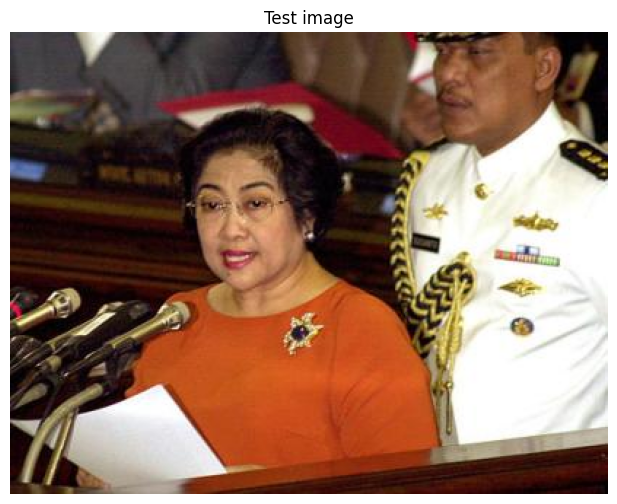

Predicted label: real
Confidence score: 100.00


In [ ]:
image_path = "/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/img_1235.jpg"
image = load_test_image(image_path=image_path, show_image=True)
# Make prediction
with torch.no_grad():  # No need to compute gradients for inference
    image = image.to(device)
    output = model(image)  # Forward pass

    # Apply softmax to get probabilities
    probabilities = tnf.softmax(output, dim=1)

    # Get the class with the highest probability
    confidence, predicted = torch.max(probabilities, 1)  # Get the class with highest probability

# Convert the prediction to a label (assuming you have a mapping of class indices to labels)
label_map = {0: "real", 1: "fake"}  # Adjust based on your dataset
predicted_label = label_map[predicted.item()]

# Print predicted label and confidence score
confidence_score = confidence.item()
print(f"Predicted label: {predicted_label}")
print(f"Confidence score: {confidence_score*100:.2f}")

## Loading Model


In [ ]:
# Assuming your model is already defined and loaded
# model = models.resnext50_32x4d()  # Replace with your actual model definition
loaded_model = torch.load(
    "/kaggle/working/model/acc98.00_test-2.1_CROPS_deepfake_detector_resnext101_32x8d.pth",
    map_location="cpu",
    weights_only=False,
)  # Load the trained model weights
loaded_model.eval()  # Set the model to evaluation mode

# If using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

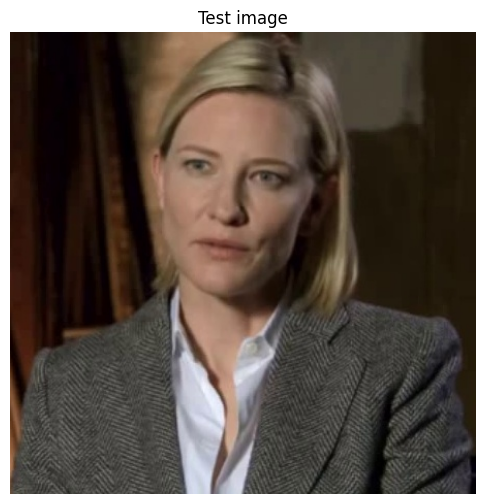

Predicted label: real
Confidence score: 98.25


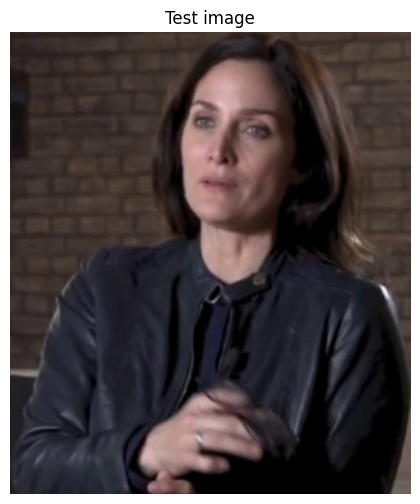

Predicted label: real
Confidence score: 99.99


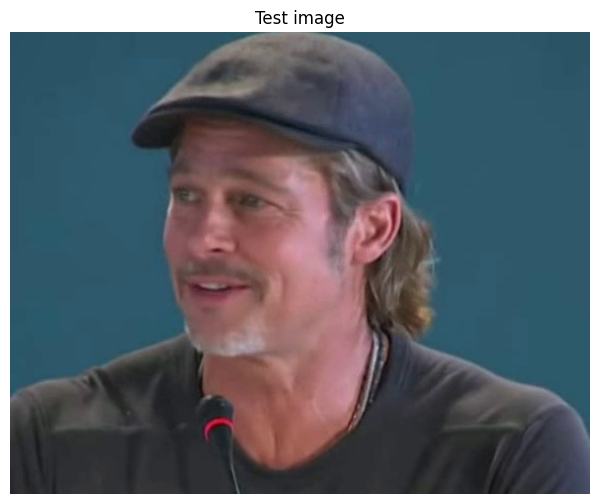

Predicted label: real
Confidence score: 99.95


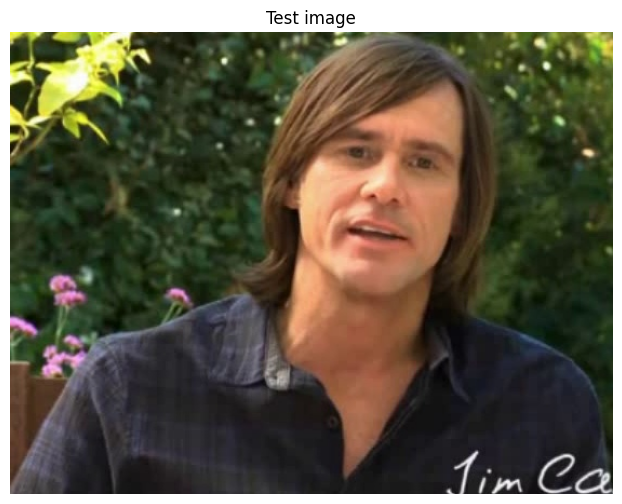

Predicted label: real
Confidence score: 100.00


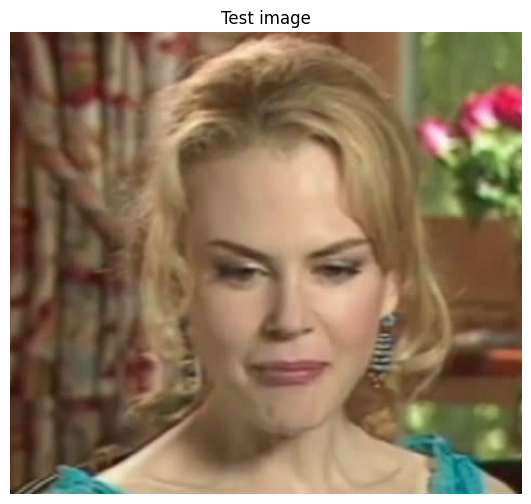

Predicted label: real
Confidence score: 100.00


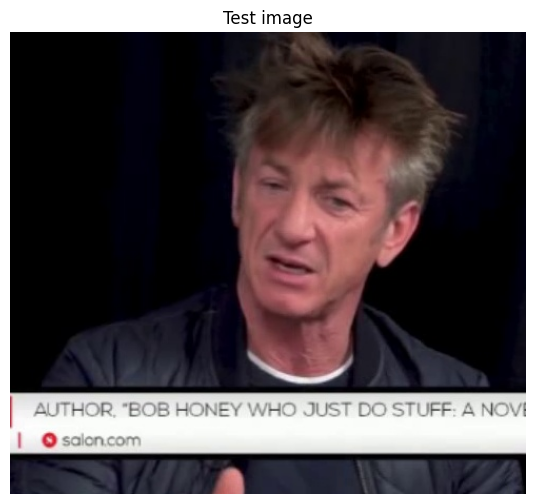

Predicted label: real
Confidence score: 99.99


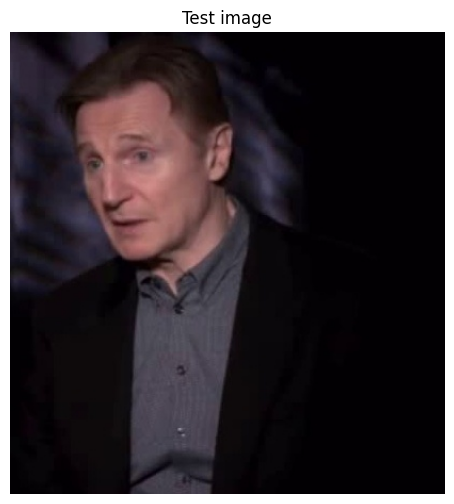

Predicted label: real
Confidence score: 99.97


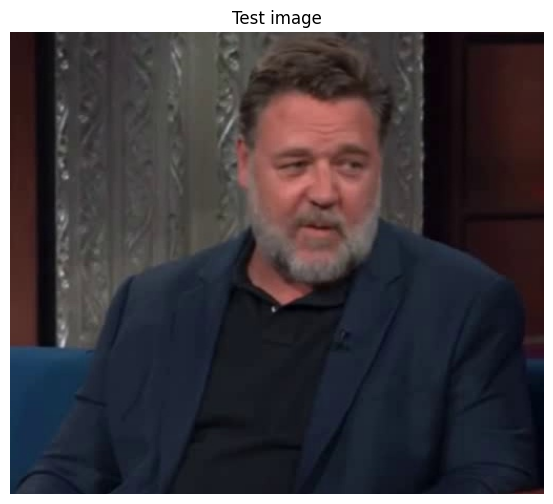

Predicted label: real
Confidence score: 100.00


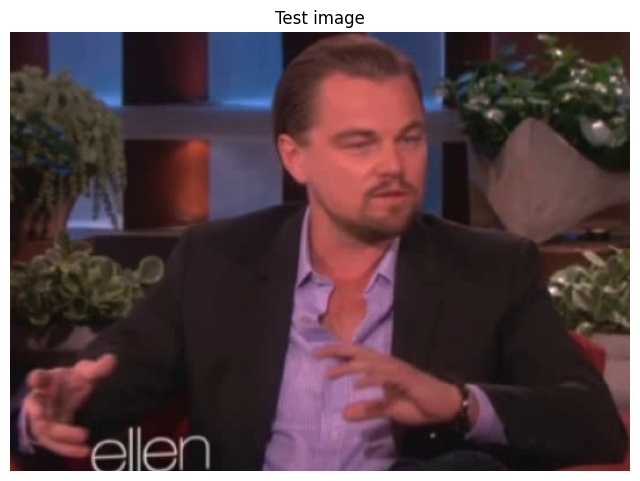

Predicted label: real
Confidence score: 99.23


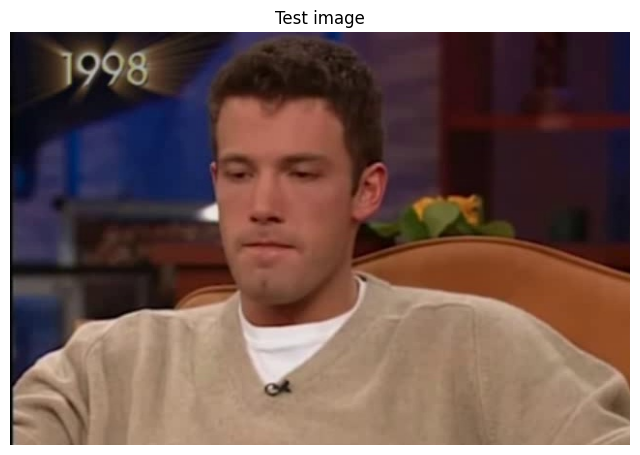

Predicted label: real
Confidence score: 100.00


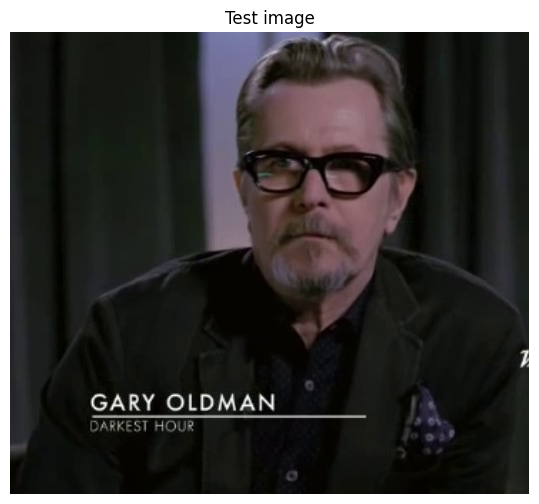

Predicted label: real
Confidence score: 99.99


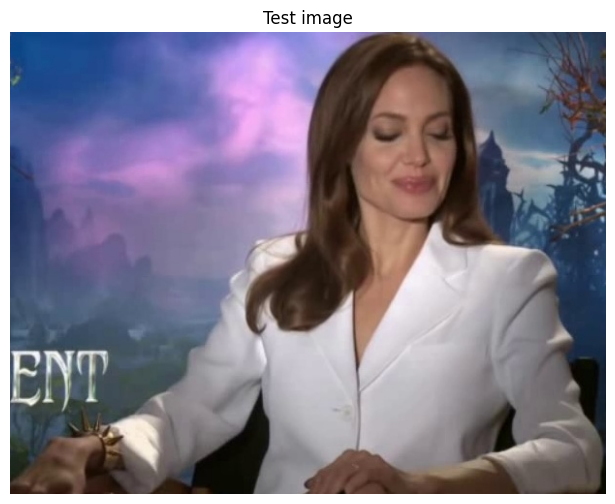

Predicted label: real
Confidence score: 75.23


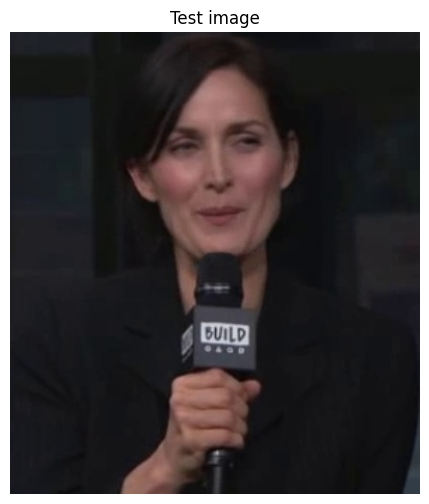

Predicted label: real
Confidence score: 99.77


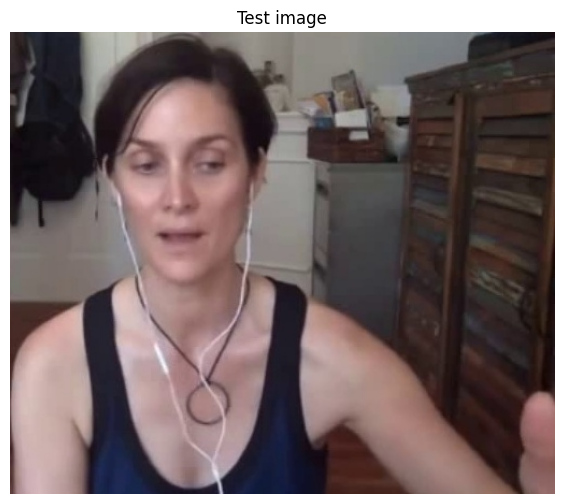

Predicted label: real
Confidence score: 100.00


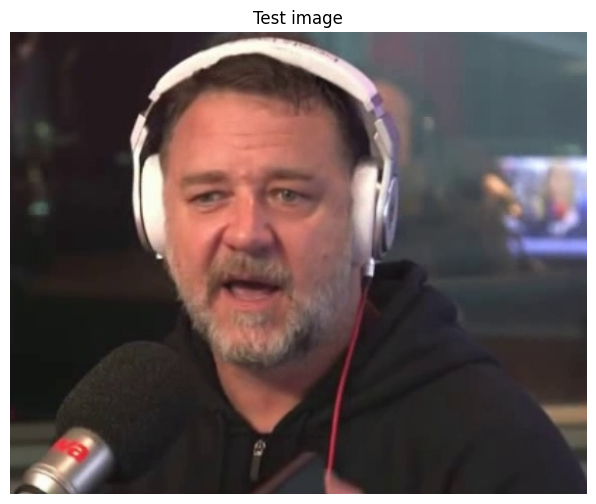

Predicted label: real
Confidence score: 100.00


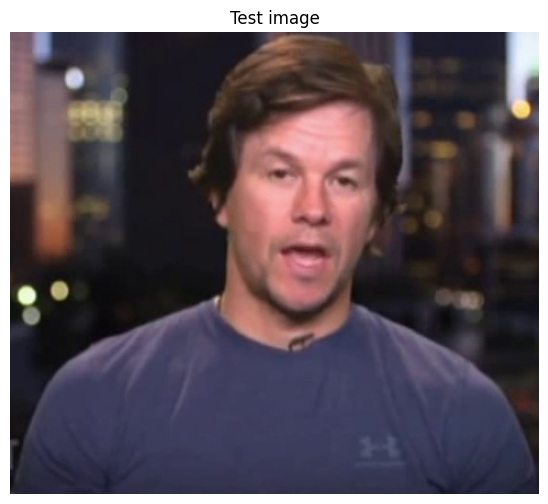

Predicted label: real
Confidence score: 100.00


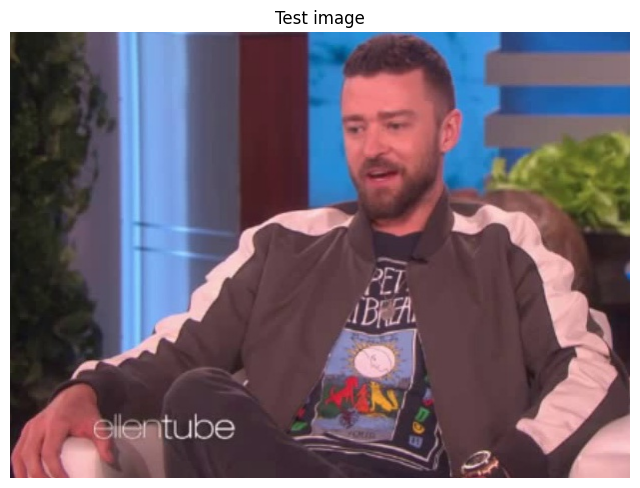

Predicted label: real
Confidence score: 100.00


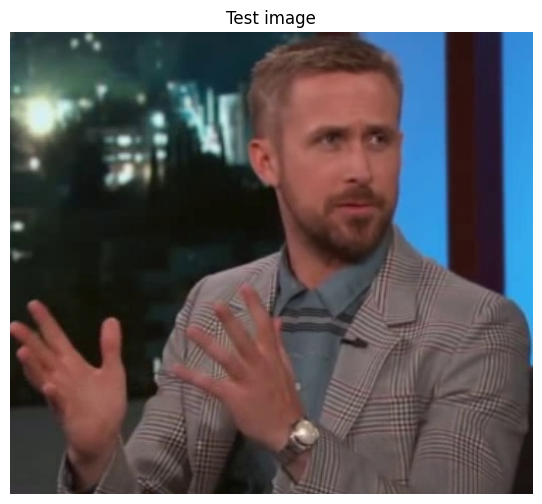

Predicted label: real
Confidence score: 100.00


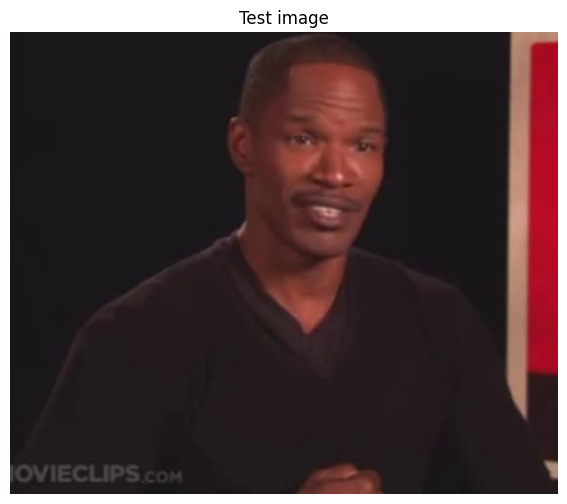

Predicted label: real
Confidence score: 100.00


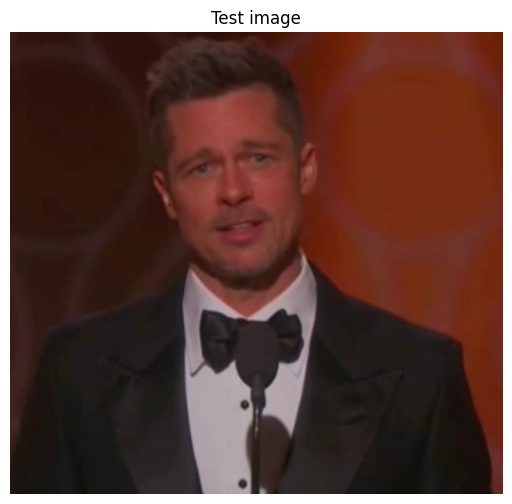

Predicted label: real
Confidence score: 100.00


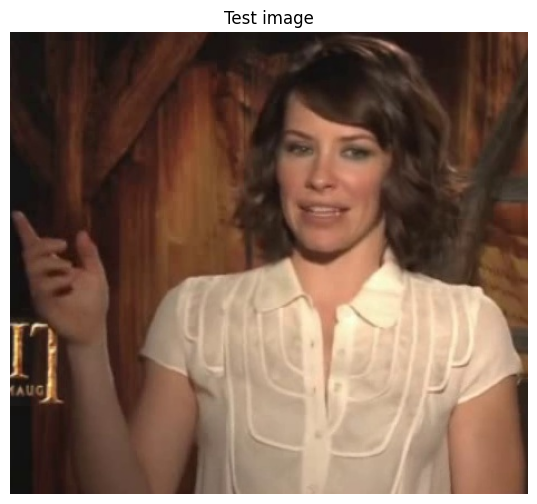

Predicted label: real
Confidence score: 100.00


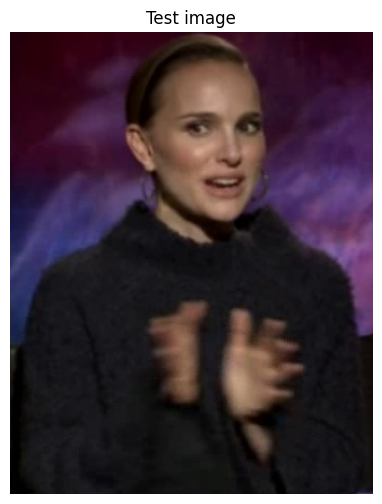

Predicted label: real
Confidence score: 100.00


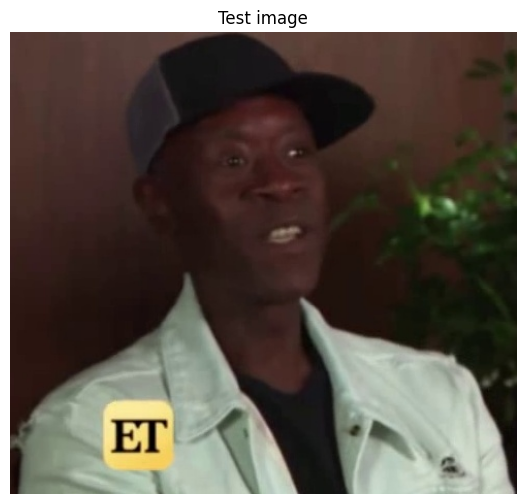

Predicted label: real
Confidence score: 99.82


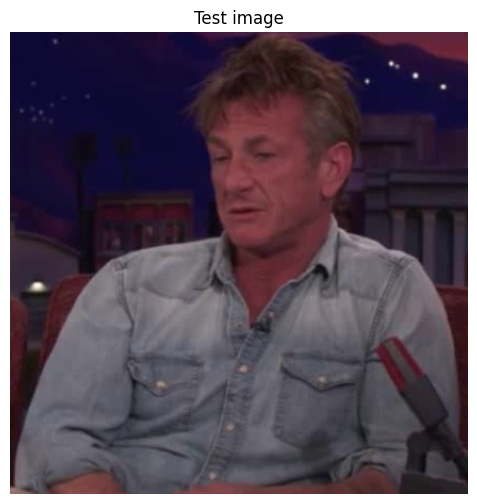

Predicted label: real
Confidence score: 100.00


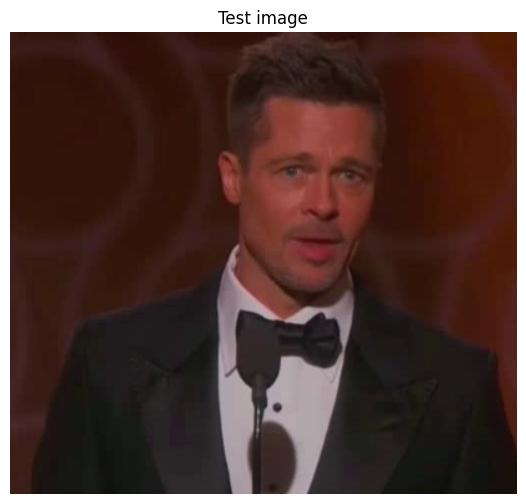

Predicted label: real
Confidence score: 100.00


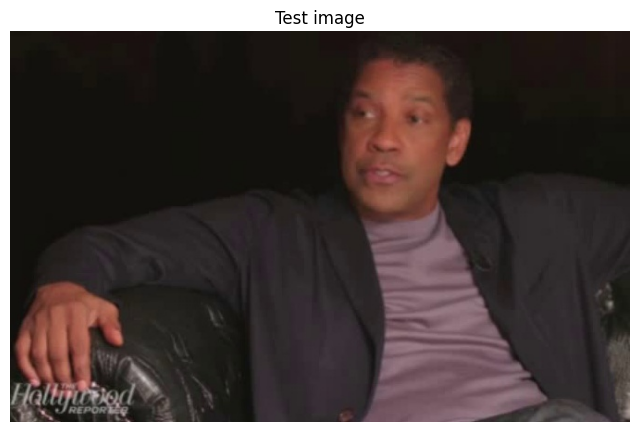

Predicted label: real
Confidence score: 99.03


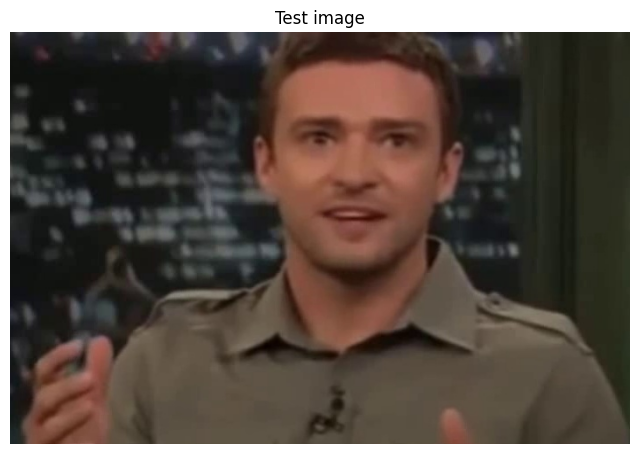

Predicted label: real
Confidence score: 99.99


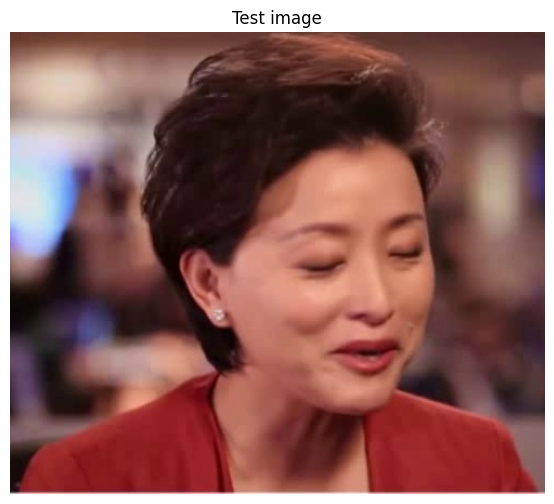

Predicted label: real
Confidence score: 99.89


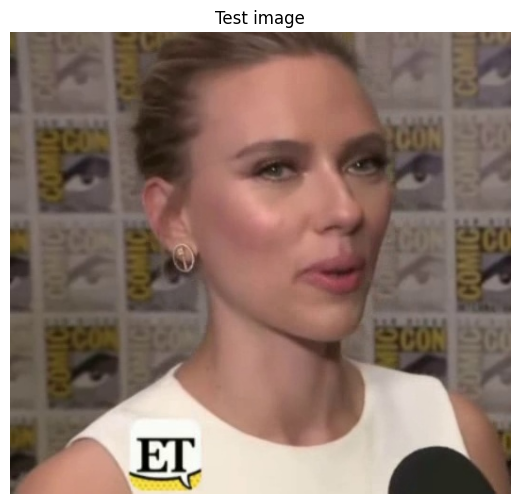

Predicted label: real
Confidence score: 98.16


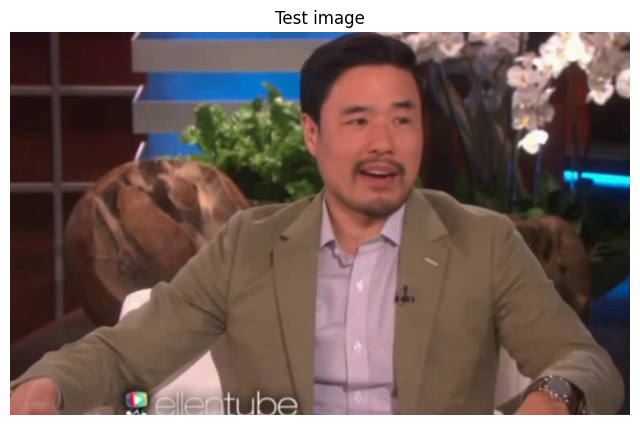

Predicted label: real
Confidence score: 99.89


In [ ]:
image_dir = "/kaggle/working/temp_face_crops/real"
images = os.listdir(image_dir)
for image_file in images[0:30]:
    image_path = os.path.join(image_dir, image_file)
    image = load_test_image(image_path=image_path, show_image=True)
    # Make prediction
    with torch.no_grad():  # No need to compute gradients for inference
        image = image.to(device)
        output = loaded_model(image)  # Forward pass

        # Apply softmax to get probabilities
        probabilities = tnf.softmax(output, dim=1)

        # Get the class with the highest probability
        confidence, predicted = torch.max(probabilities, 1)  # Get the class with highest probability

    # Convert the prediction to a label (assuming you have a mapping of class indices to labels)
    label_map = {0: "real", 1: "fake"}  # Adjust based on your dataset
    predicted_label = label_map[predicted.item()]

    # Print predicted label and confidence score
    confidence_score = confidence.item()
    print(f"Predicted label: {predicted_label}")
    print(f"Confidence score: {confidence_score*100:.2f}")

# showing example image

In [ ]:
class DeepfakeDetectionPipeline:
    def __init__(
        self,
        frame_model_path,
        crop_model_path,
        frames_dir,
        crops_dir,
        threshold=0.4,
        log_level=0,
        FRAMES_FILE_FORMAT="jpg",
    ):
        """
        Initialize the pipeline with both frame and crop models.

        Args:
            frame_model_path (str): Path to the frame analysis model
            crop_model_path (str): Path to the crop analysis model
            frames_dir (str): Directory containing all frames
            crops_dir (str): Directory containing all crops
            threshold (float): Confidence threshold for face detection
            log_level (int): Logging verbosity level
        """
        # Load models and move to appropriate device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.frame_model = torch.load(frame_model_path, map_location=self.device)
        self.crop_model = torch.load(crop_model_path, map_location=self.device)
        self.frame_model.eval()
        self.crop_model.eval()

        # Set up image transformation
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

        self.log_level = log_level
        self.label_map = {0: "real", 1: "fake"}
        self.frames_dir = frames_dir
        self.crops_dir = crops_dir
        self.FRAMES_FILE_FORMAT = FRAMES_FILE_FORMAT

        # Initialize MediaProcessor for face detection
        self.media_processor = MediaProcessor(
            threshold=threshold, log_level=log_level, FRAMES_FILE_FORMAT=self.FRAMES_FILE_FORMAT
        )

    def get_crops_for_frame(self, file_id, frame_index, crops_dir):
        """
        Get all crops belonging to a specific frame using the naming scheme.

        Args:
            file_id (str): Combined hash identifier (content_hash + name_hash)
            frame_index (int): Frame index (0 for images)
            crops_dir (str): Directory containing all crops

        Returns:
            list: Paths to relevant crop files
        """
        crop_prefix = f"{file_id}_{frame_index}_"
        relevant_crops = []

        for filename in os.listdir(crops_dir):
            if filename.startswith(crop_prefix):
                crop_path = os.path.join(crops_dir, filename)
                relevant_crops.append(crop_path)

        return natsorted(relevant_crops)  # Sort to ensure consistent ordering

    def load_image_preprocessed(self, image_path, show_image=False):
        if show_image:
            cv_img = cv2.imread(image_path)

            # Convert the image from BGR to RGB for displaying with matplotlib
            cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

            # Display the image with detected faces
            plt.figure(figsize=(8, 6))
            plt.imshow(cv_img_rgb)
            plt.axis("off")  # Hide axis
            plt.title(f"Test image")
            plt.show()

        #  Define the transformations (should be the same as used in training)
        transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),  # Resize the image to the input size of the model
                transforms.ToTensor(),  # Convert image to tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalize as per the pre-trained model's requirements
            ]
        )

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply the transformations
        image = transform(image)

        # Add a batch dimension (models expect a batch of images, even if it's just one image)
        image = image.unsqueeze(0)

        return image

    def process_frame(self, image_path, type="frame"):
        """
        Process a single frame through frame-level model with integrated GradCAM for frames only.

        Args:
            image_path (str): Path to the image file
            type (str): Type of processing, either "frame" or "crop"

        Returns:
            tuple: (predicted_label, confidence_score, gradcam_path if type=="frame" else None)
        """
        if type not in ["frame", "crop"]:
            raise ValueError("Invalid type. Expected 'frame' or 'crop'.")

        model = self.frame_model if type == "frame" else self.crop_model
        gradcam_path = None

        # Load and preprocess image
        image = self.load_image_preprocessed(image_path, show_image=False)
        image = image.to(self.device)

        # Make prediction
        with torch.no_grad():
            output = model(image)
            probabilities = tnf.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted_class = predicted.item()

        predicted_label = self.label_map[predicted_class]
        confidence_score = confidence.item()

        # Generate GradCAM only for frame-level analysis
        if type == "frame":
            gradcam_path = image_path.replace(
                f".{self.FRAMES_FILE_FORMAT}", f"_gradcam.{self.FRAMES_FILE_FORMAT}"
            )

            # Target the last convolutional layer
            target_layers = [model.layer4[-1]]

            # Create GradCAM object
            cam = GradCAM(model=model, target_layers=target_layers)

            # Define target for GradCAM
            targets = [ClassifierOutputTarget(predicted_class)]

            # Generate grayscale CAM
            grayscale_cam = cam(input_tensor=image, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Load and prepare original image for overlay
            rgb_img = cv2.imread(image_path)
            rgb_img = cv2.resize(rgb_img, (224, 224))
            # rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB) #convert BGR to RGB color space
            rgb_img = rgb_img / 255.0

            # Create visualization
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB) #convert BGR to RGB color space

            # plt.imshow(visualization)

            # Save visualization
            cv2.imwrite(gradcam_path, visualization)

            if self.log_level >= 2:
                print(f"GradCAM saved to: {gradcam_path}")

        if self.log_level >= 2:
            print(f"Type: {type}")
            print(f"Predicted label: {predicted_label}")
            print(f"Confidence score: {confidence_score*100:.2f}")

        return predicted_label, confidence_score, gradcam_path if type == "frame" else None

    def analyze_frame_with_crops(self, image_path, frame_id):
        """
        Analyze a frame both at frame-level and crop-level.

        Args:
            image_path (str): Path to the image file
            frame_id (str): Identifier for the frame

        Returns:
            dict: Analysis results including frame and crop predictions
        """
        results = {
            "frame_id": frame_id,
            "frame_analysis": None,
            "crop_analyses": [],
            "final_verdict": None,
            "frame_path": image_path,
            "crop_paths": [],
            "ela_path": None,
            "gradcam_path": None,
        }

        # Frame-level analysis with GradCAM
        frame_pred, frame_conf, gradcam_path = self.process_frame(image_path, type="frame")
        results["frame_analysis"] = {"prediction": frame_pred, "confidence": frame_conf}
        results["gradcam_path"] = gradcam_path

        # Get crops for this frame
        frame_index = 0 if "_" not in frame_id else int(frame_id.split("_")[-1])
        file_id = frame_id.rsplit("_", 1)[0]
        crop_paths = self.get_crops_for_frame(file_id, frame_index, self.crops_dir)

        # Analyze each crop (without GradCAM)
        for crop_path in crop_paths:
            crop_pred, crop_conf, _ = self.process_frame(crop_path, type="crop")

            crop_index = int(os.path.splitext(crop_path)[0].split("_")[-1])

            results["crop_analyses"].append(
                {
                    "face_index": crop_index,
                    "prediction": crop_pred,
                    "confidence": crop_conf,
                }
            )
            results["crop_paths"].append(crop_path)

        # Determine final verdict
        if len(results["crop_analyses"]) > 0:
            frame_is_fake = frame_pred == "fake"
            crops_fake_count = sum(
                1 for crop in results["crop_analyses"] if crop["prediction"] == "fake"
            )
            crops_total = len(results["crop_analyses"])

            if frame_is_fake and crops_fake_count > crops_total / 2:
                results["final_verdict"] = "fake"
            else:
                results["final_verdict"] = "real"
        else:
            results["final_verdict"] = frame_pred

        # Perform ELA analysis
        results["ela_path"] = self.perform_ela_analysis(image_path)

        return results

    def perform_ela_analysis(self, image_path):
        """
        Perform Error Level Analysis (ELA) on the image.

        Args:
            image_path (str): Path to the image file

        Returns:
            str: Path to the ELA image
        """
        ela_image_path = image_path.replace(
            f".{self.FRAMES_FILE_FORMAT}", f"_ela.{self.FRAMES_FILE_FORMAT}"
        )

        # # Skip if ELA image already exists
        # if os.path.exists(ela_image_path):
        #     if self.log_level >= 1:
        #         print(f"Skipping frame {ela_image_path}: already exists")
        #     return ela_image_path

        # Open image using PIL
        original_image = Image.open(image_path)
        temp_compressed = os.path.join(os.path.dirname(image_path), "temp_compressed.jpg")

        # Save compressed version
        quality = 95
        scale_multiplier = 50
        original_image.save(temp_compressed, "JPEG", quality=quality)
        compressed_image = Image.open(temp_compressed)

        # Calculate difference
        ela_image = ImageChops.difference(original_image, compressed_image)

        # Apply noise boost and scaling
        ela_scaled = ela_image.point(lambda x: np.sign(x) * (np.abs(x) ** 1.5 * scale_multiplier))

        # Save ELA image
        ela_scaled.save(ela_image_path)

        # Clean up temporary file
        if os.path.exists(temp_compressed):
            os.remove(temp_compressed)

        return ela_image_path

    def process_media(self, media_path, frame_rate=2):
        """
        Process a media file (image or video) through the pipeline.

        Args:
            media_path (str): Path to the media file
            frame_rate (int): Frame rate for video processing

        Returns:
            dict: Analysis results for the entire media file
        """
        media_type = self.media_processor.check_media_type(media_path)

        # Generate file identifier using MediaProcessor's hash functions
        file_id = self.media_processor.generate_combined_hash(media_path)

        # Process media file for frames using MediaProcessor
        self.media_processor.process_media_file(
            media_path, self.frames_dir, generate_crops_flag=False, frame_rate=frame_rate
        )

        # Process media file for crops using MediaProcessor
        self.media_processor.process_media_file(
            media_path, self.crops_dir, generate_crops_flag=True, frame_rate=frame_rate
        )

        results = {
            "media_path": media_path,
            "media_type": media_type,
            "file_id": file_id,
            "frame_results": [],
        }

        if media_type == "Image":
            media_path = os.path.join(self.frames_dir, f"{file_id}_0.{self.FRAMES_FILE_FORMAT}")
            frame_results = self.analyze_frame_with_crops(media_path, f"{file_id}_0")
            results["media_path"] = media_path
            results["frame_results"].append(frame_results)

        elif media_type == "Video":
            frames = [
                os.path.join(self.frames_dir, f)
                for f in os.listdir(self.frames_dir)
                if (f.startswith(file_id) and ("ela" not in f and "gradcam" not in f))
            ]
            frames = natsorted(frames)
            for frame_index, frame_path in enumerate(frames):
                # print("ID/PATH: ",frame_index, frame_path)
                frame_results = self.analyze_frame_with_crops(frame_path, f"{file_id}_{frame_index}")
                results["frame_results"].append(frame_results)

        # Calculate overall statistics
        results["statistics"] = self._calculate_statistics(results["frame_results"])

        return results

    def _calculate_statistics(self, frame_results):
        """Calculate overall statistics from frame results."""
        total_frames = len(frame_results)
        fake_frames = sum(1 for f in frame_results if f["final_verdict"] == "fake")
        total_crops = sum(len(f["crop_analyses"]) for f in frame_results)
        fake_crops = sum(
            sum(1 for crop in f["crop_analyses"] if crop["prediction"] == "fake") for f in frame_results
        )

        return {
            "total_frames": total_frames,
            "fake_frames": fake_frames,
            "fake_frames_percentage": ((fake_frames / total_frames * 100) if total_frames > 0 else 0),
            "total_crops": total_crops,
            "fake_crops": fake_crops,
            "fake_crops_percentage": ((fake_crops / total_crops * 100) if total_crops > 0 else 0),
        }

    def _save_results(self, results, output_dir):
        """Save analysis results to output directory."""
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{results['file_id']}_analysis.json")

        with open(output_path, "w") as f:
            json.dump(results, f, sort_keys=True, indent=4)

In [ ]:
# Initialize pipeline with crops directory
pipeline = DeepfakeDetectionPipeline(
    frame_model_path="/kaggle/working/model/acc99.76_test-2.1_FRAMES_deepfake_detector_resnext50.pth",
    crop_model_path="/kaggle/working/model/acc99.53_test-2.1_CROPS_deepfake_detector_resnext50.pth",
    frames_dir="/kaggle/working/temp_dataset",
    crops_dir="/kaggle/working/temp_face_crops",
    threshold=0.4,
    log_level=0,
    FRAMES_FILE_FORMAT="png",
)

# Process media file
results = pipeline.process_media(
    media_path="/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/img_1247.jpg",
    frame_rate=2,
)

# Print results
print(f"File ID: {results['file_id']}")
print(f"Media type: {results['media_type']}")
print("\nStatistics:")
print(results)
# for key, value in results["statistics"].items():
#     print(f"{key}: {value}")

Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

File ID: 4567558_11307367
Media type: Image

Statistics:
{'media_path': '/kaggle/working/temp_dataset/4567558_11307367_0.png', 'media_type': 'Image', 'file_id': '4567558_11307367', 'frame_results': [{'frame_id': '4567558_11307367_0', 'frame_analysis': {'prediction': 'real', 'confidence': 1.0}, 'crop_analyses': [{'face_index': 0, 'prediction': 'real', 'confidence': 0.9072081446647644}, {'face_index': 0, 'prediction': 'real', 'confidence': 0.9137353897094727}, {'face_index': 3, 'prediction': 'real', 'confidence': 0.9999810457229614}, {'face_index': 3, 'prediction': 'real', 'confidence': 0.9999814033508301}, {'face_index': 4, 'prediction': 'real', 'confidence': 0.922019362449646}, {'face_index': 4, 'prediction': 'real', 'confidence': 0.9720369577407837}, {'face_index': 5, 'prediction': 'real', 'confide

Found frames: ['/kaggle/working/temp_dataset/4567558_11307367_0_ela.png']


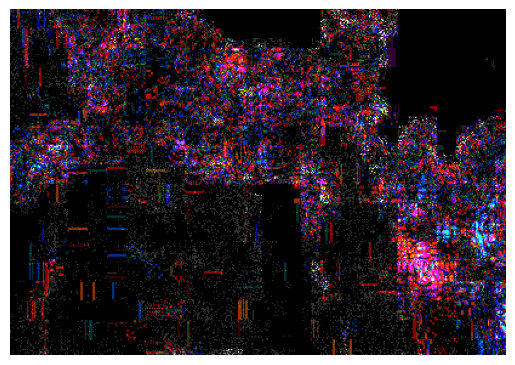

In [ ]:
# Get the list of frames
frames = [
    os.path.join("/kaggle/working/temp_dataset", f)
    for f in os.listdir("/kaggle/working/temp_dataset")
    if (f.startswith("4567558_11307367") and ("ela.png" in f))
][:1]

print("Found frames:", frames)

# Sort the frames naturally
frames = natsorted(frames)

if frames:
    for frame in frames:
        # Read first image
        image = cv2.imread(frame)

        if image is not None:

            plt.imshow(image)
            plt.axis("off")
            plt.show()
        else:
            print(f"Could not read image: {frame}")
else:
    print("No frames found matching the criteria")

In [ ]:
print(len(os.listdir("/kaggle/working/temp_dataset/fake")))
print(len(os.listdir("/kaggle/working/temp_dataset/real")))

In [ ]:
!mkdir '/kaggle/working/temp'

In [ ]:
extract_frames_with_face(
    os.listdir("/kaggle/input/celeb-df-v2-dataset/Celeb-synthesis")[-1],
    frame_output_dir="/kaggle/working/temp",
    id="frame",
    frame_rate=1,
    log_level=0,
)

# New pipeline testing


In [ ]:
class DeepfakeDetectionPipeline:
    def __init__(
        self,
        frame_model_path,
        crop_model_path,
        media_dir,
        threshold=0.4,
        log_level=0,
        FRAMES_FILE_FORMAT="jpg",
    ):
        """
        Initialize the pipeline with both frame and crop models.

        Args:
            frame_model_path (str): Path to the frame analysis model
            crop_model_path (str): Path to the crop analysis model
            media_dir (str): Base directory for media files
            threshold (float): Confidence threshold for face detection
            log_level (int): Logging verbosity level
        """
        # Load models and move to appropriate device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.frame_model = torch.load(frame_model_path, map_location=self.device)
        self.crop_model = torch.load(crop_model_path, map_location=self.device)
        self.frame_model.eval()
        self.crop_model.eval()

        # Set up image transformation
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

        self.log_level = log_level
        self.label_map = {0: "real", 1: "fake"}
        self.media_dir = media_dir
        self.FRAMES_FILE_FORMAT = FRAMES_FILE_FORMAT

        # Initialize MediaProcessor for face detection
        self.media_processor = MediaProcessor(
            threshold=threshold, log_level=log_level, FRAMES_FILE_FORMAT=self.FRAMES_FILE_FORMAT
        )

        # Create necessary directories
        self.frames_dir = os.path.join(media_dir, "frames")
        self.crops_dir = os.path.join(media_dir, "crops")
        self.ela_dir = os.path.join(media_dir, "ela")
        self.gradcam_dir = os.path.join(media_dir, "gradcam")
        self.submitted_media_dir = os.path.join(media_dir, "submitted_media")

        os.makedirs(self.frames_dir, exist_ok=True)
        os.makedirs(self.crops_dir, exist_ok=True)
        os.makedirs(self.ela_dir, exist_ok=True)
        os.makedirs(self.gradcam_dir, exist_ok=True)
        os.makedirs(self.submitted_media_dir, exist_ok=True)

    def get_crops_for_frame(self, file_id, frame_index, crops_dir):
        """
        Get all crops belonging to a specific frame using the naming scheme.

        Args:
            file_id (str): Combined hash identifier (content_hash + name_hash)
            frame_index (int): Frame index (0 for images)
            crops_dir (str): Directory containing all crops

        Returns:
            list: Paths to relevant crop files
        """
        crop_prefix = f"{file_id}_{frame_index}_"
        relevant_crops = []

        for filename in os.listdir(crops_dir):
            if filename.startswith(crop_prefix):
                crop_path = os.path.join(crops_dir, filename)
                relevant_crops.append(crop_path)

        return natsorted(relevant_crops)  # Sort to ensure consistent ordering

    def load_image_preprocessed(self, image_path, show_image=False):
        if show_image:
            cv_img = cv2.imread(image_path)

            # Convert the image from BGR to RGB for displaying with matplotlib
            cv_img_rgb = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

            # Display the image with detected faces
            plt.figure(figsize=(8, 6))
            plt.imshow(cv_img_rgb)
            plt.axis("off")  # Hide axis
            plt.title(f"Test image")
            plt.show()

        #  Define the transformations (should be the same as used in training)
        transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),  # Resize the image to the input size of the model
                transforms.ToTensor(),  # Convert image to tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalize as per the pre-trained model's requirements
            ]
        )

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Apply the transformations
        image = transform(image)

        # Add a batch dimension (models expect a batch of images, even if it's just one image)
        image = image.unsqueeze(0)

        return image

    def process_frame(self, image_path, type="frame"):
        """
        Process a single frame through frame-level model with integrated GradCAM for frames only.

        Args:
            image_path (str): Path to the image file
            type (str): Type of processing, either "frame" or "crop"

        Returns:
            tuple: (predicted_label, confidence_score, gradcam_path if type=="frame" else None)
        """
        if type not in ["frame", "crop"]:
            raise ValueError("Invalid type. Expected 'frame' or 'crop'.")

        model = self.frame_model if type == "frame" else self.crop_model
        gradcam_path = None

        # Load and preprocess image
        image = self.load_image_preprocessed(image_path, show_image=False)
        image = image.to(self.device)

        # Make prediction
        with torch.no_grad():
            output = model(image)
            probabilities = tnf.softmax(output, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted_class = predicted.item()

        predicted_label = self.label_map[predicted_class]
        confidence_score = confidence.item()

        # Generate GradCAM only for frame-level analysis
        if type == "frame":
            gradcam_path = os.path.join(
                self.gradcam_dir,
                os.path.basename(image_path).replace(
                    f".{self.FRAMES_FILE_FORMAT}", f"_gradcam.{self.FRAMES_FILE_FORMAT}"
                ),
            )

            # Target the last convolutional layer
            target_layers = [model.layer4[-1]]

            # Create GradCAM object
            cam = GradCAM(model=model, target_layers=target_layers)

            # Define target for GradCAM
            targets = [ClassifierOutputTarget(predicted_class)]

            # Generate grayscale CAM
            grayscale_cam = cam(input_tensor=image, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Load and prepare original image for overlay
            rgb_img = cv2.imread(image_path)
            rgb_img = cv2.resize(rgb_img, (224, 224))
            # rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB) #convert BGR to RGB color space
            rgb_img = rgb_img / 255.0

            # Create visualization
            visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            # visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB) #convert BGR to RGB color space

            # plt.imshow(visualization)

            # Save visualization
            cv2.imwrite(gradcam_path, visualization)

            if self.log_level >= 2:
                print(f"GradCAM saved to: {gradcam_path}")

        if self.log_level >= 2:
            print(f"Type: {type}")
            print(f"Predicted label: {predicted_label}")
            print(f"Confidence score: {confidence_score*100:.2f}")

        return predicted_label, confidence_score, gradcam_path if type == "frame" else None

    def analyze_frame_with_crops(self, image_path, frame_id):
        """
        Analyze a frame both at frame-level and crop-level.

        Args:
            image_path (str): Path to the image file
            frame_id (str): Identifier for the frame

        Returns:
            dict: Analysis results including frame and crop predictions
        """
        results = {
            "frame_id": frame_id,
            "frame_analysis": None,
            "crop_analyses": [],
            "final_verdict": None,
            "frame_path": image_path,
            "crop_paths": [],
            "ela_path": None,
            "gradcam_path": None,
        }

        # Frame-level analysis with GradCAM
        frame_pred, frame_conf, gradcam_path = self.process_frame(image_path, type="frame")
        results["frame_analysis"] = {"prediction": frame_pred, "confidence": frame_conf}
        results["gradcam_path"] = gradcam_path

        # Get crops for this frame
        frame_index = 0 if "_" not in frame_id else int(frame_id.split("_")[-1])
        file_id = frame_id.rsplit("_", 1)[0]
        crop_paths = self.get_crops_for_frame(file_id, frame_index, self.crops_dir)

        # Analyze each crop (without GradCAM)
        for crop_path in crop_paths:
            crop_pred, crop_conf, _ = self.process_frame(crop_path, type="crop")

            crop_index = int(os.path.splitext(crop_path)[0].split("_")[-1])

            results["crop_analyses"].append(
                {
                    "face_index": crop_index,
                    "prediction": crop_pred,
                    "confidence": crop_conf,
                }
            )
            results["crop_paths"].append(crop_path)

        # Determine final verdict
        if len(results["crop_analyses"]) > 0:
            frame_is_fake = frame_pred == "fake"
            crops_fake_count = sum(
                1 for crop in results["crop_analyses"] if crop["prediction"] == "fake"
            )
            crops_total = len(results["crop_analyses"])

            if frame_is_fake and crops_fake_count > crops_total / 2:
                results["final_verdict"] = "fake"
            else:
                results["final_verdict"] = "real"
        else:
            results["final_verdict"] = frame_pred

        # Perform ELA analysis
        results["ela_path"] = self.perform_ela_analysis(image_path)

        return results

    def perform_ela_analysis(self, image_path):
        """
        Perform Error Level Analysis (ELA) on the image.

        Args:
            image_path (str): Path to the image file

        Returns:
            str: Path to the ELA image
        """
        ela_image_path = os.path.join(
            self.ela_dir,
            os.path.basename(image_path).replace(
                f".{self.FRAMES_FILE_FORMAT}", f"_ela.{self.FRAMES_FILE_FORMAT}"
            ),
        )

        # # Skip if ELA image already exists
        # if os.path.exists(ela_image_path):
        #     if self.log_level >= 1:
        #         print(f"Skipping frame {ela_image_path}: already exists")
        #     return ela_image_path

        # Open image using PIL
        original_image = Image.open(image_path)
        temp_compressed = os.path.join(os.path.dirname(image_path), "temp_compressed.jpg")

        # Save compressed version
        quality = 95
        scale_multiplier = 50
        original_image.save(temp_compressed, "JPEG", quality=quality)
        compressed_image = Image.open(temp_compressed)

        # Calculate difference
        ela_image = ImageChops.difference(original_image, compressed_image)

        # Apply noise boost and scaling
        ela_scaled = ela_image.point(lambda x: np.sign(x) * (np.abs(x) ** 1.5 * scale_multiplier))

        # Save ELA image
        ela_scaled.save(ela_image_path)

        # Clean up temporary file
        if os.path.exists(temp_compressed):
            os.remove(temp_compressed)

        return ela_image_path

    def process_media(self, media_path, frame_rate=2):
        """
        Process a media file (image or video) through the pipeline.

        Args:
            media_path (str): Path to the media file
            frame_rate (int): Frame rate for video processing

        Returns:
            dict: Analysis results for the entire media file
        """
        media_type = self.media_processor.check_media_type(media_path)

        # Generate file identifier using MediaProcessor's hash functions
        file_id = self.media_processor.generate_combined_hash(media_path)

        # Process media file for frames using MediaProcessor
        self.media_processor.process_media_file(
            media_path, self.frames_dir, generate_crops_flag=False, frame_rate=frame_rate
        )

        # Process media file for crops using MediaProcessor
        self.media_processor.process_media_file(
            media_path, self.crops_dir, generate_crops_flag=True, frame_rate=frame_rate
        )

        results = {
            "media_path": media_path,
            "media_type": media_type,
            "file_id": file_id,
            "frame_results": [],
        }

        if media_type == "Image":
            media_path = os.path.join(self.frames_dir, f"{file_id}_0.{self.FRAMES_FILE_FORMAT}")
            frame_results = self.analyze_frame_with_crops(media_path, f"{file_id}_0")
            results["media_path"] = media_path
            results["frame_results"].append(frame_results)

        elif media_type == "Video":
            frames = [
                os.path.join(self.frames_dir, f)
                for f in os.listdir(self.frames_dir)
                if (f.startswith(file_id) and ("ela" not in f and "gradcam" not in f))
            ]
            frames = natsorted(frames)
            for frame_index, frame_path in enumerate(frames):
                # print("ID/PATH: ",frame_index, frame_path)
                frame_results = self.analyze_frame_with_crops(frame_path, f"{file_id}_{frame_index}")
                results["frame_results"].append(frame_results)

        # Calculate overall statistics
        results["statistics"] = self._calculate_statistics(results["frame_results"])

        return results

    def _calculate_statistics(self, frame_results):
        """Calculate overall statistics from frame results."""
        total_frames = len(frame_results)
        fake_frames = sum(1 for f in frame_results if f["final_verdict"] == "fake")
        total_crops = sum(len(f["crop_analyses"]) for f in frame_results)
        fake_crops = sum(
            sum(1 for crop in f["crop_analyses"] if crop["prediction"] == "fake") for f in frame_results
        )

        return {
            "total_frames": total_frames,
            "fake_frames": fake_frames,
            "fake_frames_percentage": ((fake_frames / total_frames * 100) if total_frames > 0 else 0),
            "total_crops": total_crops,
            "fake_crops": fake_crops,
            "fake_crops_percentage": ((fake_crops / total_crops * 100) if total_crops > 0 else 0),
        }

    def _save_results(self, results, output_dir):
        """Save analysis results to output directory."""
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, f"{results['file_id']}_analysis.json")

        with open(output_path, "w") as f:
            json.dump(results, f, sort_keys=True, indent=4)

In [ ]:
# Initialize pipeline with media directory
pipeline = DeepfakeDetectionPipeline(
    frame_model_path="/kaggle/working/model/acc99.76_test-2.1_FRAMES_deepfake_detector_resnext50.pth",
    crop_model_path="/kaggle/working/model/acc99.53_test-2.1_CROPS_deepfake_detector_resnext50.pth",
    media_dir="/kaggle/working/media",
    threshold=0.4,
    log_level=0,
    FRAMES_FILE_FORMAT="png",
)

# Process media file
results = pipeline.process_media(
    media_path="/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/img_1252.jpg",
    frame_rate=2,
)

# Print results
print(f"File ID: {results['file_id']}")
print(f"Media type: {results['media_type']}")
print("\nStatistics:")
print(results)

Reason: Image input

Image: {file_content_hash}_{file_name_hash}_{frame_index=0}_{crop_index}.{extension}
Video: {file_content_hash}_{file_name_hash}_{frame_index}_{crop_index}.{extension}

Unsupported media type: Invalid image file
Unsupported media type: Invalid image file
File ID: 10406151_9680266
Media type: Invalid image file

Statistics:
{'media_path': '/kaggle/input/test-images-for-face-detection-pipeline-samples/test_images_for_face_detection_pipeline/img_1252.jpg', 'media_type': 'Invalid image file', 'file_id': '10406151_9680266', 'frame_results': [], 'statistics': {'total_frames': 0, 'fake_frames': 0, 'fake_frames_percentage': 0, 'total_crops': 0, 'fake_crops': 0, 'fake_crops_percentage': 0}}
